# CarND-Advanced-Lane-Lines

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Python Module Imports

In [1]:
# Imports needed for project.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

#### Camera Calibration with OpenCV
#### Run the code in the cell below to extract object points and image points for camera calibration.

In [2]:
# Based off code from
# https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Grid size
grid_x = 9
grid_y = 6

objp = np.zeros((grid_y*grid_x,3), np.float32)
objp[:,:2] = np.mgrid[0:grid_x, 0:grid_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('calibration_wide/GO*.jpg')
#
# These images were provided by the workspace.
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (grid_x, grid_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        

#### Run the cell below to calibrate, calculate distortion coefficients

In [3]:
# Function was from exercise in lesson 5 - Camera Calibration - 12. Correcting for Distortion
# and looking at the code from 
# https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# to calibrate, calculate distortion coefficients, and test undistortion on an image.
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #undist = np.copy(img)  # Delete this line
    #return undist
    
    return dst

#### Rubric Criteria - Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

From lesson 5 - Camera Calibration - 11. Calibrating Your Camera, there are example code for reading in images via glob API or cv2, converting to grayscale, finding chessboard corners, drawing detected corners on an image, camera calibration given object points, image points, and the shape of the grayscale image, and then undistorting the image.

From lesson 5 - Camera Calibration - 12. Correcting for Distortion, a Jupyter notebook was given as an example to extract object points and image points https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

As shown in the first cell above, I first extract object points and image points for camera calibration. I am assuming the chessboard is fixed on the (x,y) plane with z=0, such that the object points are the same for each calibration image. The variable objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection. The second cell is a function to calibrate, calculate distortion coefficients. The input for the function is objpoints and imgpoints to compute the camera calibration and distortion coefficients. What is returned is the undistorted image. This was made into a function because so it can be called multiple times in the Jupyter notebook. Two cv2 methods were used, cv2.calibrateCamera() and cv2.undistort(). 


##### Test undistortion on an image,  an example of a distortion corrected calibration image

Text(0.5,1,'Undistorted Image')

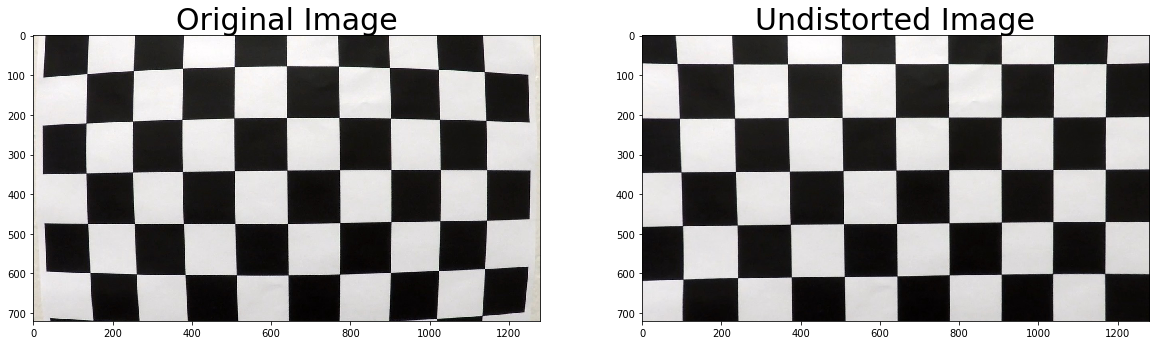

In [4]:
# Taken from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# Visualize undistortion
#
# Load a calibration image
#img = cv2.imread('camera_cal/calibration1.jpg')
#
# Using mpimg instead of cv2 in order to avoid rearrageing color channels
img = mpimg.imread('camera_cal/calibration1.jpg')
#
# Undistort the image using the function defined in the cell above.
img_undist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Apply a distortion correction to raw images.

#### Rubric Criteria - Provide an example of a distortion-corrected image.

Text(0.5,1,'Undistorted Image')

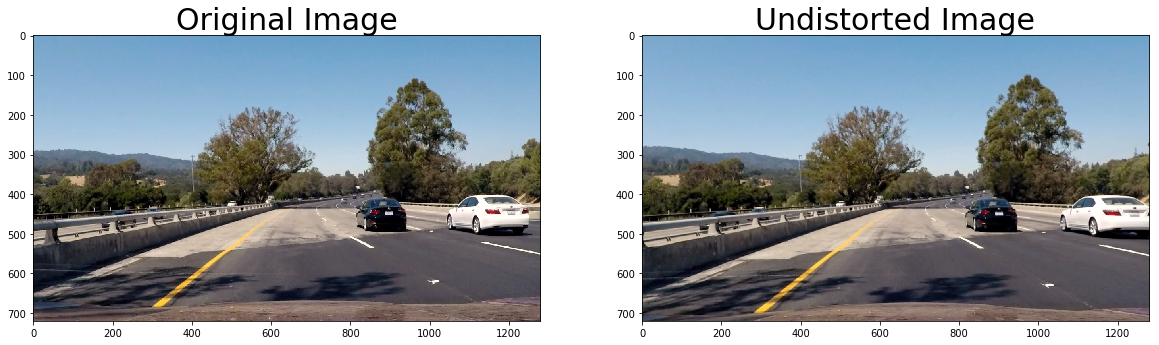

In [5]:
# Load a test image
#img = cv2.imread('test_images/test1.jpg')
#
# Using mpimg instead of cv2 in order to avoid rearrageing color channels
img = mpimg.imread('test_images/test4.jpg')
#
# Undistort the image using the function defined in the cell above.
img_undist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

At first glance, it may be hard to tell the difference between the two images. If you noticed in the original image, screen right, the white car's right back light is visible. In the undistorted image, the same white car's right back light is not visible. This is an indication that the undistort method is doing something to the image. Testing with checkerboards makes the visible effect more obvious.

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
# From lesson 6- Gradients and Color Spaces - 3. Applying Sobel
# Modified to take in sobel_kernel.

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    thresh_min, thresh_max = thresh[0], thresh[1]
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    dx , dy = 1, 0
    if orient == 'y':
        dx, dy = 0, 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
# From lesson 6- Gradients and Color Spaces - 4. Magnitude of the Gradient

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [8]:
# From lesson 6- Gradients and Color Spaces - 5. Direction of the Gradient

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    thresh_min, thresh_max = thresh
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_direction)
    binary_output[(gradient_direction >= thresh_min) & (gradient_direction <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [9]:
# From lesson 6 - Gradients and Color Spaces - 11. HLS Quiz
#
# Modified the original name, signature of the function
# and initial values for keyword arguments.
#
# Also changed channel selector so it can take other channels beside s (saturation.)

# Define a function that thresholds the S-channel of HLS
#def hls_select(img, thresh=(0, 255)):
def color_thresh(img, channel='s', thresh=(150,200)):
    thresh_min, thresh_max = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    def_channel = s_channel
    if channel == 'h':
        def_channel = h_channel
    elif channel == 'l':
        def_channel = l_channel
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(def_channel >= thresh_min) & (def_channel <= thresh_max)] = 1
    return s_binary

In [10]:
# Set the kernel size for the Sobel operators
sobel_kernel_size = 9

# Read image
image = mpimg.imread('test_images/test3.jpg')

# Use the functions defined above.
# Guessing and testing different values for hyperparameters thresholds and kernel sizes
#
x_grad = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel_size, thresh=(40, 200))
y_grad = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel_size, thresh=(50, 150))
#
# NOTE: The sobel kernel for magnitude threshold is different than the others.
mag_binary = mag_thresh(image, sobel_kernel=15, thresh=(30,100))
dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel_size, thresh=(0.9, 1.6))

# Values from example in lesson 6 - Gradients and Color Spaces - 12. Color and Gradient
s_threshold = color_thresh(image, channel='s', thresh=(170, 255))

# Combine the two binary thresholds
combined = np.zeros_like(x_grad)
#
# Changed the condition.
# Instead of using 
#combined_binary[(x_grad == 1) | (y_grad == 1)] = 1
combined[(x_grad == 1) & (x_grad == 1)] = 1


#### Rubric Criteria - Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color threshold, by converting from RGB to HLS color space, gradient threshold (on the x axis), sobel operator (on the x axis). I then combined the two binary thresholds (threshold x gradient and threshold y gradient). I displayed the original image, the S threshold (i.e. the color threshold,) the threshold x and y gradient, the combined threshold x gradient and threshold y gradient, and the magnitude of the gradient.

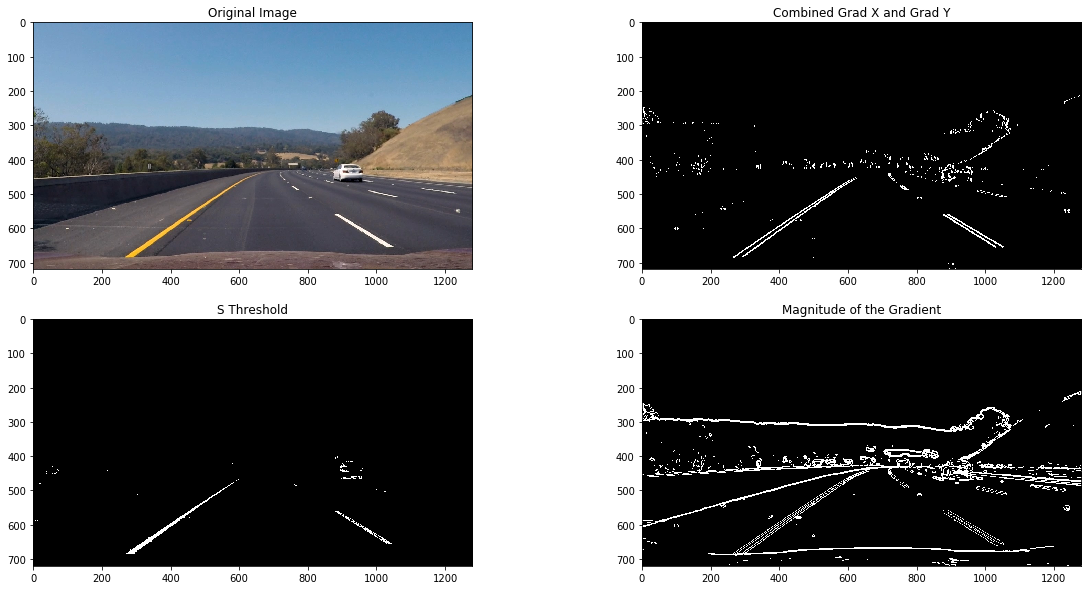

In [11]:
# Plotting similar to what was shown in
# From lesson 6 - Gradients and Color Spaces - 12. Color and Gradient

# Plotting thresholded images
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f, ax_ndarray = plt.subplots(2, 2, figsize=(20,10))
ax_flatten = ax_ndarray.ravel()

ax_flatten[0].set_title('Original Image')
ax_flatten[0].imshow(image)

ax_flatten[1].set_title('Combined Grad X and Grad Y')
ax_flatten[1].imshow(combined, cmap='gray')

ax_flatten[2].set_title('S Threshold')
ax_flatten[2].imshow(s_threshold, cmap='gray')

ax_flatten[3].set_title('Magnitude of the Gradient')
ax_flatten[3].imshow(mag_binary, cmap='gray')


### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [34]:
def warper(img,src,dst,img_size):
    
    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Get the inverse transformation matrix
    Minv= cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    
    return (warped, M, Minv)

# Define functions to help with masking colors.
def color_mask(hsv,low,high):
    return cv2.inRange(hsv, low, high)

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    return cv2.bitwise_and(img,img, mask= mask)

In [24]:
# Read the image
img = mpimg.imread('test_images/test2.jpg')

In [25]:
# Hyperparameter
# Map points from source to destination using percentages from the center of the img

# Undistort the image based on the fractions of the current image size.
img = cal_undistort(img, objpoints, imgpoints)
img_size = np.shape(img)
image_top = np.uint(img_size[0]/1.55)
image_bottom = np.uint(img_size[0])
image_center = np.uint(img_size[1]/2)
image_top_left = image_center - .145*np.uint(img_size[1]/2)
image_top_right = image_center + .145*np.uint(img_size[1]/2)
image_bottom_left = image_center - .95*np.uint(img_size[1]/2)
image_bottom_right = image_center + .95*np.uint(img_size[1]/2)

src = np.float32([[image_bottom_left,image_bottom],[image_bottom_right,image_bottom],[image_top_right,image_top],[image_top_left,image_top]])

dst = np.float32([[image_bottom_left,img_size[0]],[image_bottom_right,img_size[0]],
                  [image_bottom_right,0],[image_bottom_left,0]])

In [26]:
# Get warped image
warped, M, Minv = warper(img,src,dst,(img_size[1],img_size[0]))

#### Rubric Criteria - Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

There is a function called warper(). It takes arguments img, src, and dst. img is the image that will be transformed. src and dst are hyperparameters that are hardcoded. The values are based on fractions of the current image size, which makes it dynamic to different images. Originally, I used the values from writeup_template.md, but I ended up modifying them.

Text(0.5,1,'Original Warped')

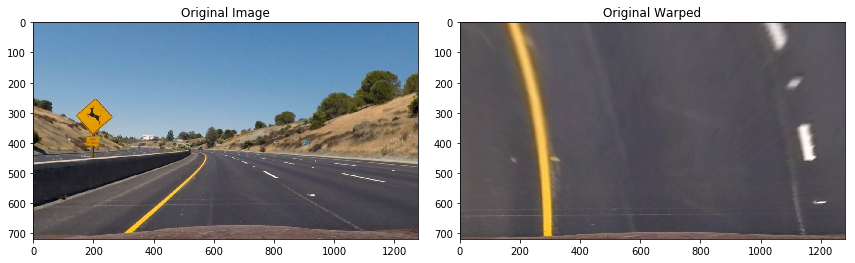

In [27]:
# Convert from RGB to HSV
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

# Define low and high threshold for color yellow.
yellow_hsv_low  = np.array([ 0,  75,  100])
yellow_hsv_high = np.array([ 80, 255, 255])

# Define low and high threshold for color white.
white_hsv_low  = np.array([ 0,   0,   230])
white_hsv_high = np.array([ 255,  35, 255])

x_grad = abs_sobel_thresh(warped, orient='x', sobel_kernel=9, thresh=(40, 200))
combined = np.zeros_like(x_grad)

mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)

combined[(mask_lane>=.5)|(x_grad>=.5)]=1

# Plot the result
f, axs = plt.subplots(1, 2, figsize=(12,15))
axs = axs.ravel()
f.tight_layout()

axs[0].imshow(img)
axs[0].set_title('Original Image')

axs[1].imshow(warped,cmap='gray')
axs[1].set_title('Original Warped')

### 5. Detect lane pixels and fit to find the lane boundary.

In [35]:
def binary_pipeline(img, objpoints, imgpoints):
    image = cal_undistort(img, objpoints, imgpoints)
    img_size = np.shape(image)
    
    img_size = np.shape(img)
    image_top = np.uint(img_size[0]/1.55)
    image_bottom = np.uint(img_size[0])
    image_center = np.uint(img_size[1]/2)
    image_top_left = image_center - .145*np.uint(img_size[1]/2)
    image_top_right = image_center + .145*np.uint(img_size[1]/2)
    image_bottom_left = image_center - .95*np.uint(img_size[1]/2)
    image_bottom_right = image_center + .95*np.uint(img_size[1]/2)

    src = np.float32([[image_bottom_left,image_bottom],[image_bottom_right,image_bottom],[image_top_right,image_top],[image_top_left,image_top]])

    dst = np.float32([[image_bottom_left,img_size[0]],[image_bottom_right,img_size[0]],
                      [image_bottom_right,0],[image_bottom_left,0]])


    warped, M, Minv = warper(image,src,dst,(img_size[1],img_size[0]))
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV).astype(np.float)
    yellow_hsv_low  = np.array([ 0,  75,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])

    white_hsv_low  = np.array([ 0,   0,   230])
    white_hsv_high = np.array([ 255,  35, 255])


    yellow_mask = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)
    white_mask = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=9, thresh=(60, 200))
    combined = np.zeros_like(gradx)

    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white)

    combined[(mask_lane>=.5)|(gradx>=.5)]=1
    return combined, Minv

In [36]:
img = mpimg.imread('test_images/test2.jpg')
img_undist = cal_undistort(img, objpoints, imgpoints)
binary_warped, _ = binary_pipeline(img_undist, objpoints, imgpoints)

In [64]:
# From lesson 7 - Advanced Computer Vision - 4. Finding the Lines: Sliding Window

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

In [65]:
# From lesson 7 - Advanced Computer Vision - 5. Finding the Lines: Search from Prior

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_lane_inds, right_lane_inds

#### Rubric Criteria - Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The code is from lesson 7 - Advanced Computer Vision - 4. Finding the Lines: Sliding Window. How it works is it uses a histogram from the bottom of the image. By looking at the two picks of the histogram, it determines the left and right side halves of the histogram. This is the starting point of the two left and right lines. Sliding window then is used. What it does is move a window from the starting point upwards. It than determines where the lane lines go by checking the values again. The center of the value is where the next point for the line to draw will be. There are hyperparameters to set, the number of sliding windows, the width of the search windows plus and minus margin, the minimum number of pixel found to recenter window.

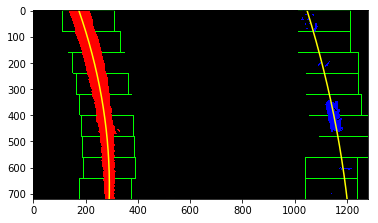

In [66]:
# Using full sliding window algorithm
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

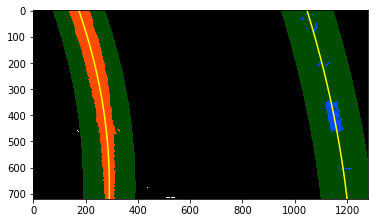

In [67]:
# Using search from prior, more efficient that searching the whole image from scratch.

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,  left_lane_inds, right_lane_inds = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [74]:
# From lesson 7 - Advanced Computer Vision - 7. Measuring Curvature I
# and
# From lesson 7 - Advanced Computer Vision - 8. Measuring Curvature II
#
# NOTE: The functions have to be updated because the examples used in the lesson used fake data generated from the 
#       method generate_data().

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

# Modifying this method
def measure_curvature_real(img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
#     # Calculation of R_curve (radius of curvature)
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
#     return left_curverad, right_curverad

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds]  
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]

    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

#### Rubric Criteria - Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

To compute the radius of curvature of the lane by computing the radius of curvature of the polynomial fit. Fitting for f(y) because the lane lines in the warped image are near vertical and may have the same x value for more than one y value. The radius of 

Rcurve = [1 + (dx/dy)^2]^(3/2)/|d^2x/dy^2|,

In the case of the second order polynomial above, the first and second derivatives are
f'(y) = dx/dy = 2Ay + B
f''(y) = d^2/dy^2 = 2A

our equation for radius of curvature becomes

Rcurve = (1 + (2Ay + B)^2)^(3/2)/|2A|

Tuturial https://www.intmath.com/applications-differentiation/8-radius-curvature.php

The position of the vehicle with respect to center have to be taken into consideration. It is
Distance from center is image x midpoint - mean of l_fit and r_fit intercepts.
But the radius of curvature for our lane lines are in pixel values, which is not the same as real world space. For this project, we can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide, according to lesson 7 - Advanced Computer Vision - 8. Measuring Curvature II.

Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 (meters per pixel in y dimension), xm_per_pix = 3.7/700 (meters per pixel in x dimension)

In [75]:
leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)
left_curverad, right_curverad, center_dist = measure_curvature_real(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print("Left CurveRad:", left_curverad, 'm')
print("Right CurveRad:", right_curverad,'m')
print("Distance from Center:", center_dist,'m')

Left CurveRad: 636.333649446 m
Right CurveRad: 1222.68683579 m
Distance from Center: -0.556538656382 m


### 7. Warp the detected lane boundaries back onto the original image.

In [46]:
# This function had to be done in the last project.

# Create an img to draw the lines on
def draw_lane(img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
   
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank img
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original img space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original img
    result = cv2.addWeighted(new_img, 1, newwarp, 0.4, 0)
    
    return result

In [77]:
# This function had to be done in the last project.
# This overlays data on the image.

def draw_data(image, left_curverad,right_curverad,center_dist):
    curv_rad = (left_curverad + right_curverad)/2.0
    new_img = np.copy(image)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Average Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

#### Rubric Criteria - Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

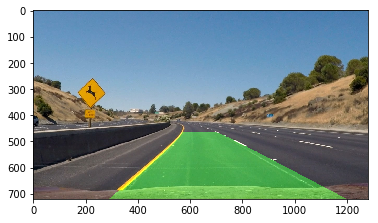

In [79]:
img = mpimg.imread('test_images/test2.jpg')
binary_warped, _ = binary_pipeline(img_undist, objpoints, imgpoints)
result = draw_lane(img, binary_warped, left_fit, right_fit, Minv)
plt.imshow(result)

#### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

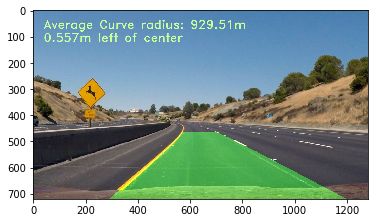

In [80]:
# Draw information on the image.
result2 = draw_data(result, left_curverad,right_curverad,center_dist)
plt.imshow(result2)

### Making video

In [82]:
# From Project: Advanced Land Finding - 2. Tips and Tricks for the Project.
class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                    
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest 5
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [99]:
line_temp = Line()
line_temp.add_fit(left_fit, left_lane_inds)

In [100]:
# Function used in last project.

# Global function to be use
l_line = Line()
r_line = Line()

def process_image(image):
    new_img = np.copy(image)
    binary_warped, Minv = binary_pipeline(image, objpoints, imgpoints)
    img_out = new_img
    
    # This is not efficient.
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)
    l_fit = np.polyfit(lefty, leftx, 2)
    r_fit = np.polyfit(righty, rightx, 2)
    l_lane_inds = left_lane_inds
    r_lane_inds = right_lane_inds
      
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)


    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, binary_warped, l_line.best_fit, r_line.best_fit, Minv)
        left_curverad, right_curverad, center_dist = curverad_and_center_dist(binary_warped, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, left_curverad, right_curverad, center_dist)
    
    return img_out



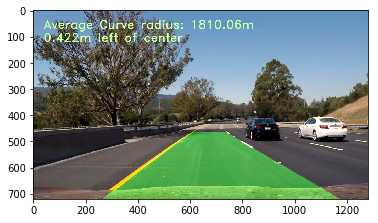

In [101]:
# Test if process_image method is working.
image = mpimg.imread('test_images/test6.jpg')
res = process_image(image)
plt.imshow(res)

In [103]:
l_line = Line()
r_line = Line()
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output1 = './project_video_output_test.mp4'
#video_input1 = VideoFileClip('./project_video.mp4').subclip(0,1)
video_input1 = VideoFileClip('./project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./project_video_output_test.mp4
[MoviePy] Writing video ./project_video_output_test.mp4


100%|█████████▉| 1260/1261 [11:02<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output_test.mp4 

CPU times: user 8min 25s, sys: 32.8 s, total: 8min 58s
Wall time: 11min 5s


### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

Here's a [link to my video result](./project_video_output.mp4) (located ./project_video_output.mp4)

#### Rubric Criteria - Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The major problems/issues I faced is coming up with good hyperparameters. Also, choosing a good binary image to use for line dectection. It seemed that combining gradient X and gradient Y worked (at least looked visually) better than combining gradient x with s_threshold as demonstrated in the lecture. Issues that could arise, is different lighting conditions. The hyperparameters would probably need to be re-calibrated and it would be likely to fail if the settings are not the same as they were when they were calibrated. The code is likely to fail on roads that do not have likes. The code assumes the camera is perfectly in the center of the car as well. If the camera shift, that would throw off where the car is located. What could be done to make it more robust is if the code can set the hyperparameters automatically. If the road have inclines where the car goes up or down hill, the lane line angles would change and the perspective transform would be off.